#  Data processing 

This notebook cleans raw data and extracts relevant attributes for the RCT prediction task. Then processed data are split into train and test set.

In [1]:
%config Completer.use_jedi = False
import os
from os.path import dirname
root_path = dirname(dirname(os.getcwd()))
print(root_path)
import sys
sys.path.append(root_path + '/RemainingCycleTimePrediction/2_Scripts/')
from zipfile import ZipFile
import pandas as pd

pd.set_option('display.max_columns', None)
data_dir = root_path + '/RemainingCycleTimePrediction/1_Data/'
project_dir = root_path + '/RemainingCycleTimePrediction/'

/home/ec2-user


## 1. Clean raw data

### Helpdesk

In [2]:
# specifying the zip file name
file_name = data_dir + "HelpDesk2017.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    raw_data = pd.read_csv(zip.open("finale.csv"))
    
raw_data.head()

File Name                                             Modified             Size
finale.csv                                     2022-05-18 11:37:22      3271588
readme.txt                                     2022-05-18 11:37:22          833


,Case ID,Activity,Resource,Complete Timestamp,Variant,Variant index,Variant.1,seriousness,customer,product,responsible_section,seriousness_2,service_level,service_type,support_section,workgroup
0,Case 1,Assign seriousness,Value 1,2012/10/09 14:50:17.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1
1,Case 1,Take in charge ticket,Value 1,2012/10/09 14:51:01.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1
2,Case 1,Take in charge ticket,Value 2,2012/10/12 15:02:56.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 2,Value 1,Value 1,Value 1
3,Case 1,Resolve ticket,Value 1,2012/10/25 11:54:26.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 2,Value 1,Value 1,Value 1
4,Case 1,Closed,Value 3,2012/11/09 12:54:39.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 2,Value 1,Value 1,Value 1


In [3]:
# Drop columns that we do not consider in the task of remaning time prediction
data = raw_data.drop(["Variant index","Variant.1","seriousness", "service_level"], axis = 1)
# Drop cases related to more than 1 customer
colname = "customer"
df = data.groupby("Case ID")[colname].unique().to_frame().reset_index()
df["Nb_customers"] = df[colname].apply(len)
list_case_with_several_customers = list(df[df.Nb_customers > 1]["Case ID"])
data = data[data["Case ID"].isin(list_case_with_several_customers) == False]

# Keep only cases ending with "closed" activity
df = data.groupby('Case ID').last().reset_index()
list_unclosed_cases = list(df[df.Activity != 'Closed']['Case ID'].unique())
data = data[data["Case ID"].isin(list_unclosed_cases) == False]
data = data.sort_values(["Case ID", "Complete Timestamp"]).reset_index(drop = True)

# Extract attributes used in the RCT problem
tab_all = data[["Case ID", "Activity", "Complete Timestamp"]]
tab_all.columns = ["Case_ID", "Activity", "timestamp"]
tab_all.timestamp = tab_all.timestamp.str.split('.', expand = True)[0]
tab_all.to_csv(data_dir+"Helpdesk_processed_all.csv", index = False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### BPIC20

In [4]:
# specifying the zip file name
file_name = data_dir + "BPIC20.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    raw_data = pd.read_csv(zip.open("data/bpi20.csv"), sep = ";")
raw_data.head()

File Name                                             Modified             Size
data/bpi20.csv                                 2021-01-28 11:02:34      9959564
data/traffic_fines.csv                         2018-04-14 14:16:02     64285237


,BudgetNumber,DeclarationNumber,Amount,Case ID,Activity,Resource,id,Role,Complete Timestamp,duration,month,weekday,hour,elapsed,remtime
0,budget 86566,other,600.844121,declaration 100000,Declaration SUBMITTED by EMPLOYEE,STAFF MEMBER,other,EMPLOYEE,2018-01-30 08:20:07+00:00,0.000000,1,1,8,0.0,1152673.0
1,budget 86566,other,600.844121,declaration 100000,Declaration APPROVED by ADMINISTRATION,STAFF MEMBER,other,ADMINISTRATION,2018-02-07 08:58:46+00:00,11558.650000,2,2,8,693519.0,459154.0
2,budget 86566,other,600.844121,declaration 100000,Declaration FINAL_APPROVED by SUPERVISOR,STAFF MEMBER,other,SUPERVISOR,2018-02-08 09:59:05+00:00,1500.316667,2,3,9,783538.0,369135.0
3,budget 86566,other,600.844121,declaration 100000,Request Payment,SYSTEM,other,UNDEFINED,2018-02-09 11:42:49+00:00,1543.733333,2,4,11,876162.0,276511.0
4,budget 86566,other,600.844121,declaration 100000,Payment Handled,SYSTEM,other,UNDEFINED,2018-02-12 16:31:20+00:00,4608.516667,2,0,16,1152673.0,0.0


In [5]:
list_cases = list(raw_data[(raw_data["remtime"]==0)&(raw_data["Activity"]=='Payment Handled')]["Case ID"])
new_data = raw_data[raw_data["Case ID"].isin(list_cases)]
tab_all = new_data[["Case ID", "Activity", "Complete Timestamp"]]
tab_all.columns = ["Case_ID", "Activity", "timestamp"]
tab_all = tab_all.reset_index(drop = True)
tab_all.timestamp = tab_all.timestamp.str.replace("-", "/")
tab_all.timestamp = tab_all.timestamp.str.split('+', expand = True)[0]
tab_all.to_csv(data_dir+"BPIC20_processed_all.csv", index = False)

## 2. Split data into train and test

In [6]:
tab_all_helpdesk = pd.read_csv(data_dir+"Helpdesk_processed_all.csv")
tab_all_bpic20 = pd.read_csv(data_dir+"BPIC20_processed_all.csv")
split_ratio = 2/3

### Helpdesk

In [7]:
split_ratio = 2/3
first_act_tab = tab_all.groupby('Case_ID').first().sort_values('timestamp').reset_index()
first_act_tab = first_act_tab[~first_act_tab.duplicated(subset=["Case_ID", "Activity"], keep = "first")]
first_act_tab = first_act_tab.reset_index(drop = True)
list_train_valid_cases = list(first_act_tab[: int(split_ratio*len(first_act_tab))]["Case_ID"].unique())

list_train_cases = list_train_valid_cases[:int(len(list_train_valid_cases)*0.8)]
tab_train = tab_all[tab_all["Case_ID"].isin(list_train_cases)].reset_index(drop = True)
tab_train.to_csv(data_dir+"Helpdesk_processed_train.csv", index = False)

list_valid_cases = list_train_valid_cases[int(len(list_train_valid_cases)*0.8):]
tab_valid = tab_all[tab_all["Case_ID"].isin(list_valid_cases)].reset_index(drop = True)
tab_valid.to_csv(data_dir+"Helpdesk_processed_valid.csv", index = False)

list_test_cases = list(first_act_tab[int(split_ratio*len(first_act_tab)):]["Case_ID"].unique())
tab_test = tab_all[tab_all["Case_ID"].isin(list_test_cases)].reset_index(drop = True)
tab_test.to_csv(data_dir+"Helpdesk_processed_test.csv", index = False)

### BPIC20

In [8]:
first_act_tab = tab_all.groupby('Case_ID').first().sort_values('timestamp').reset_index()
first_act_tab = first_act_tab[~first_act_tab.duplicated(subset=["Case_ID", "Activity"], keep = "first")]
first_act_tab = first_act_tab.reset_index(drop = True)
list_train_valid_cases = list(first_act_tab[: int(split_ratio*len(first_act_tab))]["Case_ID"].unique())

list_train_cases = list_train_valid_cases[:int(len(list_train_valid_cases)*0.8)]
tab_train = tab_all[tab_all["Case_ID"].isin(list_train_cases)].reset_index(drop = True)
tab_train.to_csv(data_dir+"BPIC20_processed_train.csv", index = False)

list_valid_cases = list_train_valid_cases[int(len(list_train_valid_cases)*0.8):]
tab_valid = tab_all[tab_all["Case_ID"].isin(list_valid_cases)].reset_index(drop = True)
tab_valid.to_csv(data_dir+"BPIC20_processed_valid.csv", index = False)

list_test_cases = list(first_act_tab[int(split_ratio*len(first_act_tab)):]["Case_ID"].unique())
tab_test = tab_all[tab_all["Case_ID"].isin(list_test_cases)].reset_index(drop = True)
tab_test.to_csv(data_dir+"BPIC20_processed_test.csv", index = False)

## 3. Generating process model

We use the PM4Py package developed for the process mining in python (https://pm4py.fit.fraunhofer.de/). See Readme.md to install this package.

In [9]:
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.common import visualizer as vis

In [10]:
# Compute the dfg graph with occurences count from a dataframe
def get_dfg_frequency(tab):
    tab = tab.sort_values(["Case_ID", "timestamp"])
    tab_reduced = tab[["Case_ID", "Activity"]]
    tab_reduced_shifted = tab_reduced.shift(-1)
    tab_reduced_shifted.columns = [str(col) + '_2' for col in tab_reduced_shifted.columns]
    tab_successive_rows = pd.concat([tab_reduced, tab_reduced_shifted], axis=1)
    tab_successive_rows = tab_successive_rows[tab_successive_rows["Case_ID"] == tab_successive_rows["Case_ID" + '_2']]
    directly_follows_grouping = tab_successive_rows.groupby(["Activity", "Activity_2"])
    dfg_frequency = directly_follows_grouping.size().to_dict()
    return dfg_frequency

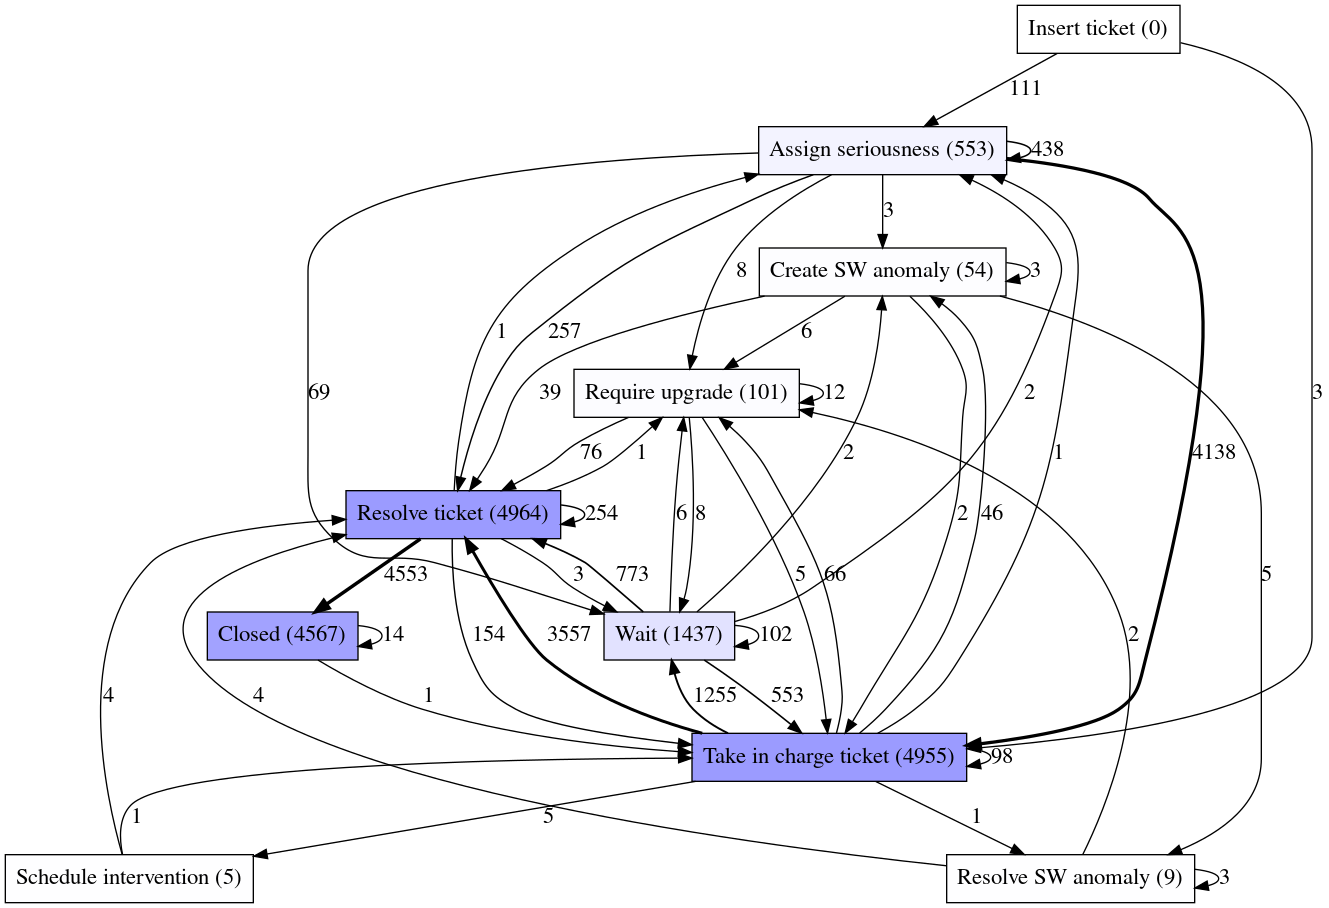

In [11]:
dfg_frequency = get_dfg_frequency(tab_all_helpdesk)
# Visualize the FDG graph
parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.ACTIVITY_KEY:"Activity", 
              dfg_visualization.Variants.FREQUENCY.value.Parameters.TIMESTAMP_KEY:"Complete Timestamp",
              dfg_visualization.Variants.FREQUENCY.value.Parameters.FONT_SIZE: 17}
gviz = dfg_visualization.apply(dfg_frequency, log=None, variant=dfg_visualization.Variants.FREQUENCY, 
                               parameters = parameters)

dfg_visualization.view(gviz)
vis.save(gviz, project_dir+ '4_Outputs/Figures/DFG_Helpdesk.png')

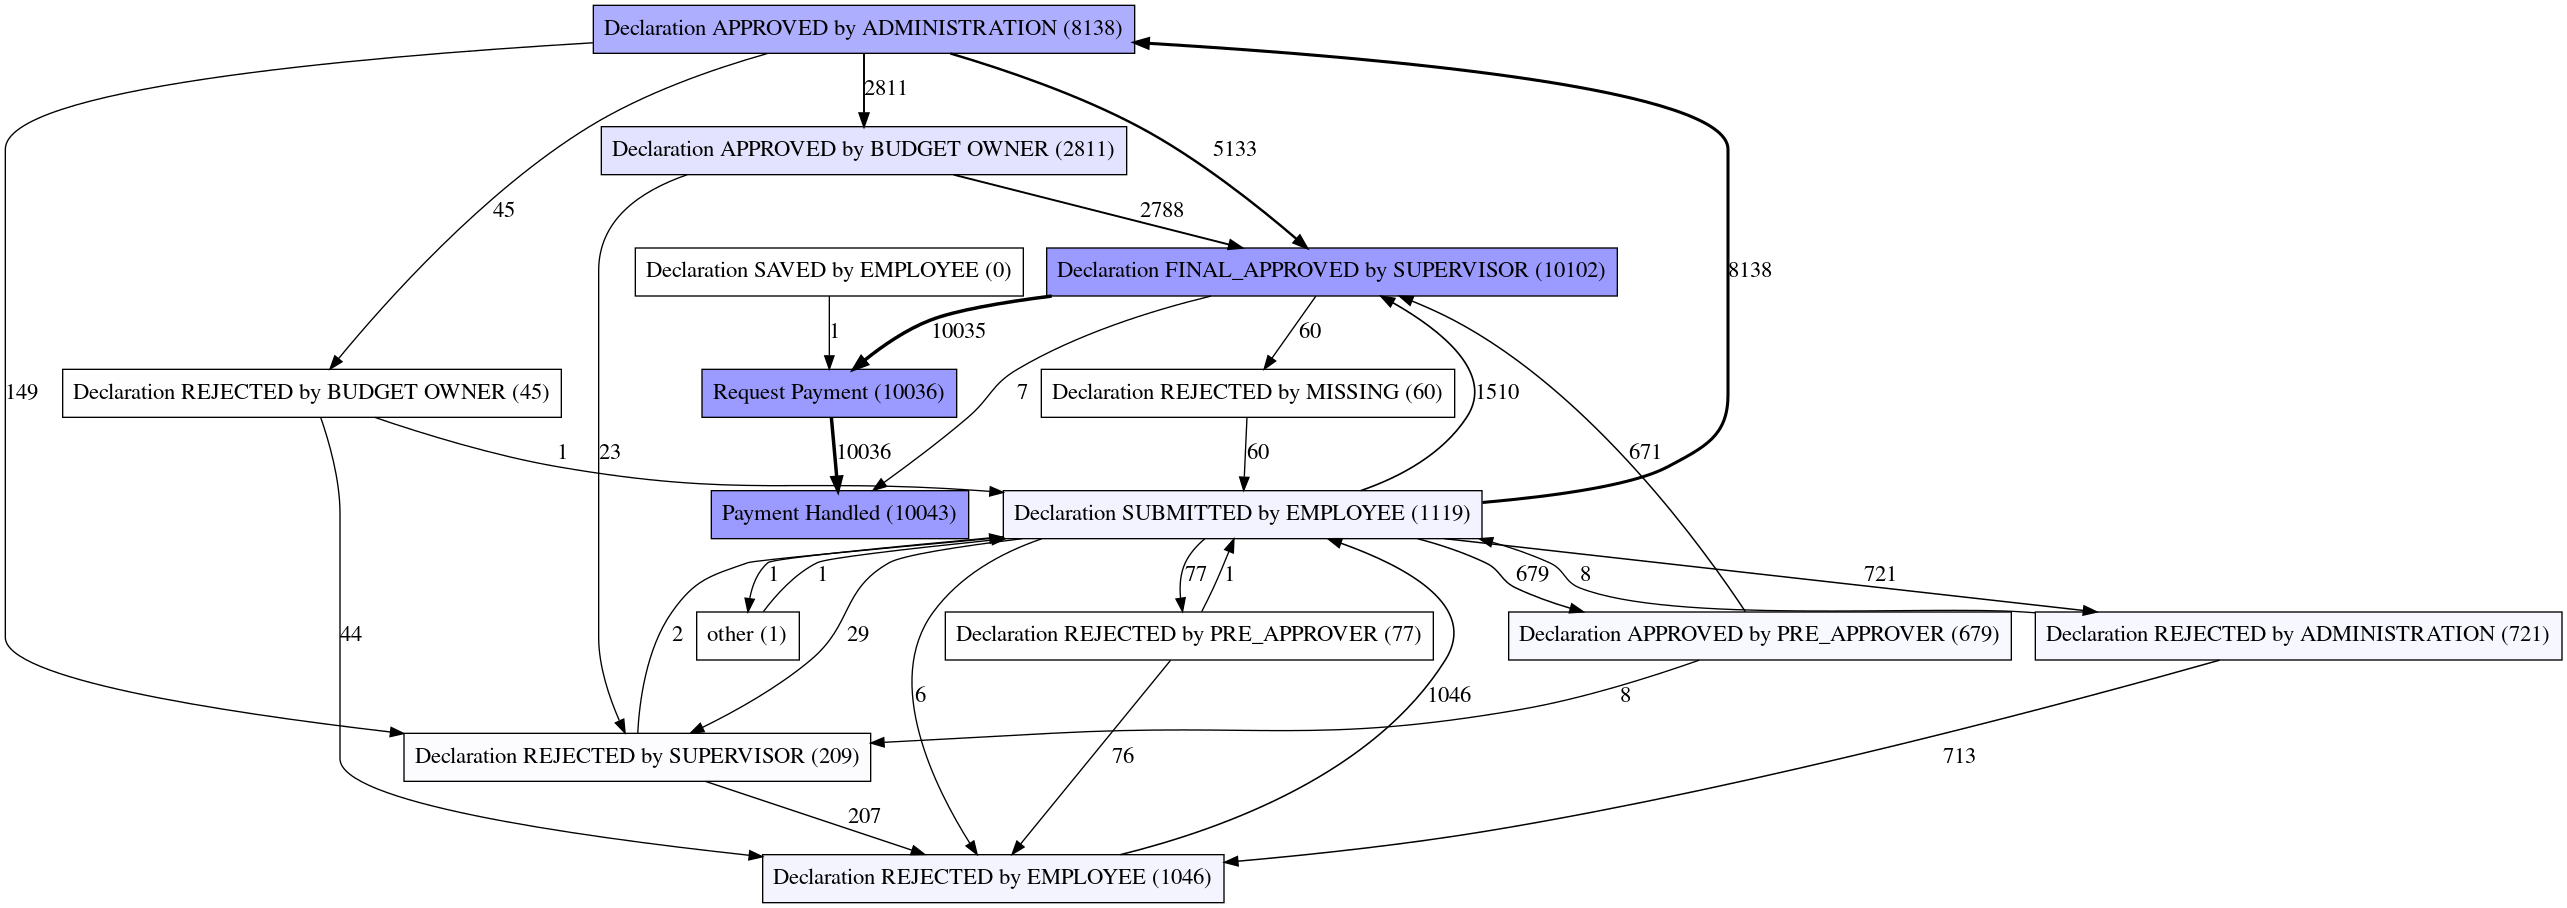

In [12]:
dfg_frequency = get_dfg_frequency(tab_all_bpic20)
# Visualize the FDG graph
parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.ACTIVITY_KEY:"Activity", 
              dfg_visualization.Variants.FREQUENCY.value.Parameters.TIMESTAMP_KEY:"Complete Timestamp",
              dfg_visualization.Variants.FREQUENCY.value.Parameters.FONT_SIZE: 17}
gviz = dfg_visualization.apply(dfg_frequency, log=None, variant=dfg_visualization.Variants.FREQUENCY, 
                               parameters = parameters)

dfg_visualization.view(gviz)
vis.save(gviz, project_dir+ '4_Outputs/Figures/DFG_BPIC20.png')